In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

In [2]:
train = pd.read_csv('input/train.csv')

train_num = train.select_dtypes(exclude=['object'])
train_num.fillna(0,inplace=True)
print(len(train_num))

test = pd.read_csv('input/test.csv')
test.fillna(0,inplace=True)

1460


In [3]:
train_cat = train.select_dtypes(exclude=['int64', 'float64'])
print(len(train_num))
train_cat.head(10)


1460


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,Shed,WD,Normal
6,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
7,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,Attchd,RFn,TA,TA,Y,NaN,NaN,Shed,WD,Normal
8,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,Fa,TA,Y,NaN,NaN,NaN,WD,Abnorml
9,RL,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,Attchd,RFn,Gd,TA,Y,NaN,NaN,NaN,WD,Normal


In [4]:
train_id = train['Id']
test_id = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [5]:
for dataset in train_num, test:
    dataset['Surface'] = dataset['GrLivArea'] + dataset['TotalBsmtSF']

In [6]:
train_2_feats = train_num[['Surface', 'SalePrice']]
train_2_feats.head()

,Surface,SalePrice
0,2566,208500
1,2524,181500
2,2706,223500
3,2473,140000
4,3343,250000


In [7]:
test['SalePrice'] = ""
test_2_feats = test[['Surface', 'SalePrice']]
test_2_feats.head(10)

,Surface,SalePrice
0,1778.0,
1,2658.0,
2,2557.0,
3,2530.0,
4,2560.0,
5,2418.0,
6,2355.0,
7,2254.0,
8,2641.0,
9,1764.0,


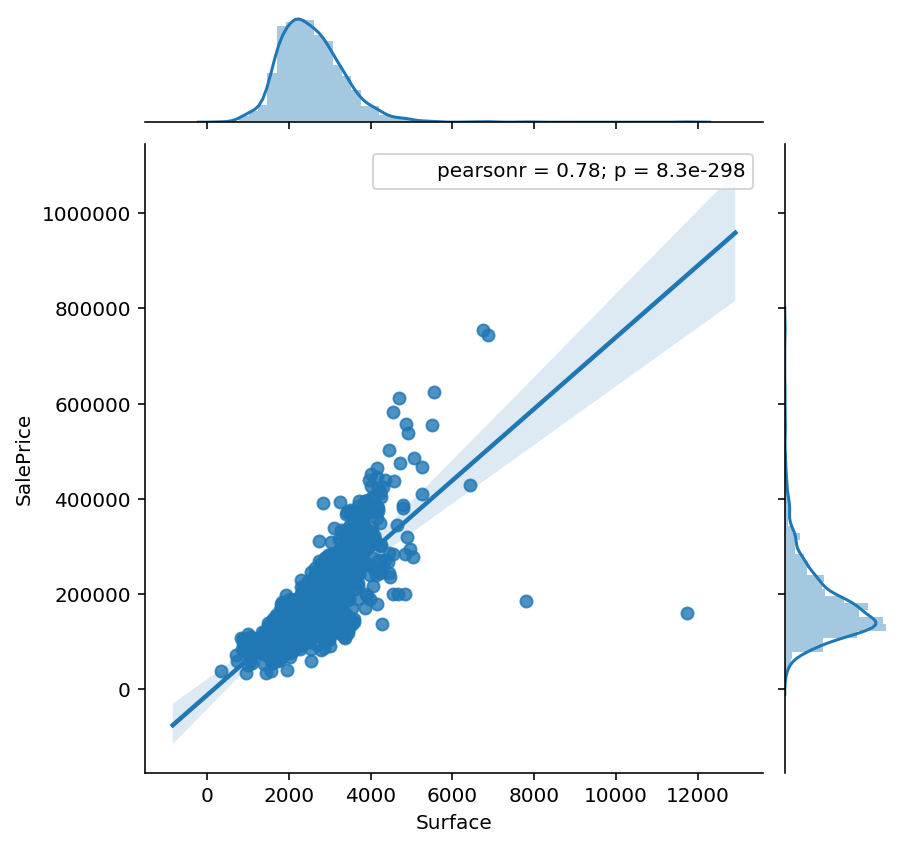

In [8]:
sns.jointplot(x=train_2_feats['Surface'], y = train_2_feats['SalePrice'], kind='reg').annotate(pearsonr)

Remove outliers

In [9]:
clf = IsolationForest(max_samples = 100, random_state=42)
clf.fit(train_2_feats)
y_not_outlier = clf.predict(train_2_feats)
y_not_outlier = pd.DataFrame(y_not_outlier, columns = ['Outlier'])

y_not_outlier[y_not_outlier['Outlier'] == 1].index.values
y_not_outlier.head(10)

print(len(train_2_feats))

#train.head(10)

1460


In [10]:
train_2_feats = train_2_feats.iloc[y_not_outlier[y_not_outlier['Outlier'] == 1].index.values]
train_2_feats.reset_index(drop = True, inplace = True)

In [11]:
print(len(train_2_feats))

1314


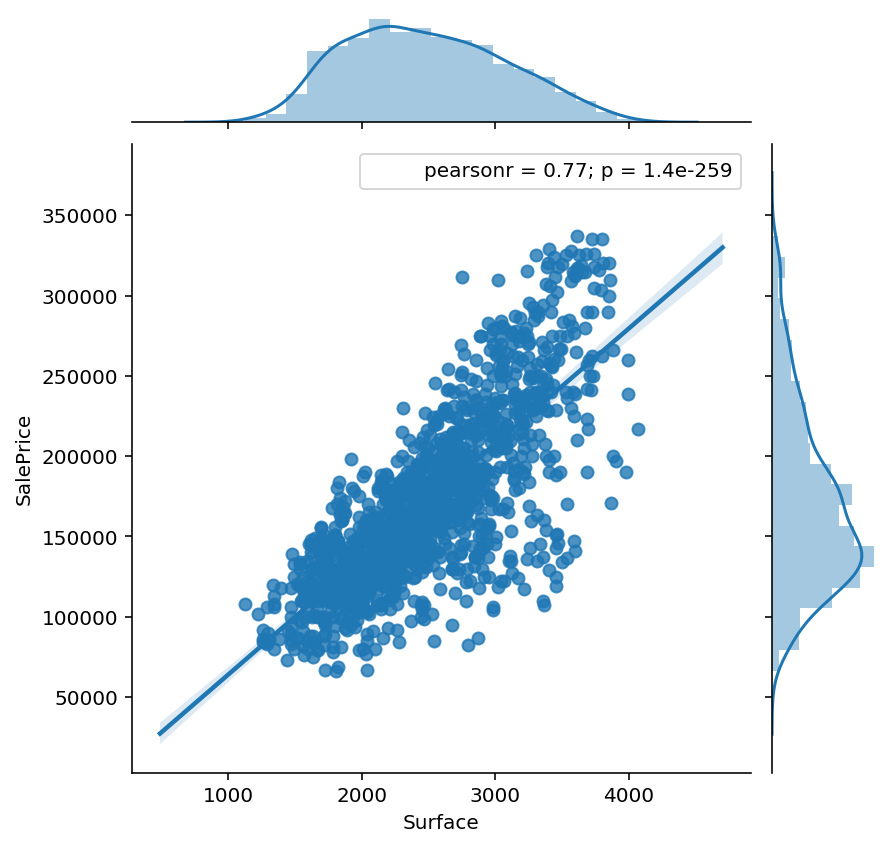

In [12]:
sns.jointplot(x=train_2_feats['Surface'], y = train_2_feats['SalePrice'], kind='reg').annotate(pearsonr)

In [13]:
# Combining Datasets
rows_train = train.shape[0]
rows_test = test.shape[0]

y_train = train.SalePrice.values
y_train

combined = pd.concat((train, test)).reset_index(drop = True)
combined.drop(['SalePrice'], axis=1, inplace=True)
combined.shape

print(f"Train dataset size: {train.shape}")
print(f"Test dataset size: {test.shape}")
print(f"Combined dataset(train + test) size: {combined.shape}")

Train dataset size: (1460, 80)
Test dataset size: (1459, 81)
Combined dataset(train + test) size: (2919, 80)


One hot Encoding

In [14]:
#for dataset in train_cat, test:
#    dataset = pd.get_dummies(dataset)
    
train_2_feats['Neighborhood'] = train['Neighborhood']
train_2_feats

,Surface,SalePrice,Neighborhood
0,2566,208500,CollgCr
1,2524,181500,Veenker
2,2706,223500,CollgCr
3,2473,140000,Crawfor
4,3343,250000,NoRidge
...,...,...,...
1309,2600,175000,SawyerW
1310,3615,210000,Crawfor
1311,3492,266500,CollgCr
1312,2156,142125,NoRidge


In [15]:
from sklearn.preprocessing import LabelEncoder


lbl = LabelEncoder() 
lbl.fit(train_2_feats['Neighborhood'].values) 
train_2_feats['Neighborhood'] = lbl.transform(train_2_feats['Neighborhood'].values)


In [16]:
train_2_feats

,Surface,SalePrice,Neighborhood
0,2566,208500,5
1,2524,181500,24
2,2706,223500,5
3,2473,140000,6
4,3343,250000,15
...,...,...,...
1309,2600,175000,20
1310,3615,210000,6
1311,3492,266500,5
1312,2156,142125,15


In [17]:
target = 'SalePrice'

X = train_num.drop(target, axis=1).values
Y = train_num.SalePrice.values

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_num, Y, test_size=0.3, random_state=42)

In [19]:
xgbr = xgb.XGBRegressor()

In [20]:
X_val

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Surface
892,893,20,70.0,8414,6,8,1963,2003,0.0,663,...,0,0,0,0,0,0,2,2006,154500,2127
1105,1106,60,98.0,12256,8,5,1994,1995,362.0,1032,...,32,0,0,0,0,0,4,2010,325000,4085
413,414,30,56.0,8960,5,6,1927,1950,0.0,0,...,0,130,0,0,0,0,3,2010,115000,2036
522,523,50,50.0,5000,6,7,1947,1950,0.0,399,...,24,36,0,0,0,0,10,2006,159000,2668
1036,1037,20,89.0,12898,9,5,2007,2008,70.0,1022,...,0,0,0,0,0,0,9,2009,315500,3240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,332,20,70.0,8176,5,6,1958,1992,0.0,846,...,0,0,0,0,0,0,8,2007,139000,2112
323,324,20,49.0,5820,3,8,1955,2005,0.0,256,...,98,0,0,0,0,0,7,2006,126175,2325
650,651,60,65.0,8125,7,6,2007,2007,0.0,0,...,0,0,0,0,0,0,5,2008,205950,2478
439,440,50,67.0,12354,6,8,1920,2000,0.0,0,...,46,0,0,0,0,800,8,2009,110000,1880


In [21]:
xgbr.fit(X_train, y_train)

[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
scores_xgbr = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score XGBoost: %.2f" % scores_xgbr.mean())

[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score XGBoost: 1.00


In [23]:
y_pred_xgbr = xgbr.predict(X_val)
mse_xgbr = mean_squared_error(y_val, y_pred_xgbr)
print("MSE XGBR: %.4f" % mse_xgbr)
print("RMSE XGBR: %.4f" % np.sqrt(mse_xgbr))

MSE XGBR: 42373267.5642
RMSE XGBR: 6509.4752


In [24]:
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)
print("MAE XGBR: %.4f" % mae_xgbr)


MAE XGBR: 988.9268


In [25]:
msle_xgbr = mean_squared_log_error(y_val, y_pred_xgbr)
print("MSLE XGBR: %.4f" % msle_xgbr)

MSLE XGBR: 0.0002
